In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.inputs.tf_keras import PlotLossesCallback
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
# Paths and parameters
best_cars_model_path = 'best_cars_model.h5'
train_path = 'data/train'
valid_path = 'data/valid'
TARGET_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 64
N_EPOCHS = 100

# Load annotations
column_names = ['filename', 'x_min', 'y_min', 'x_max', 'y_max', 'class']
train_annotations = pd.read_csv(os.path.join(train_path, '_annotations.csv'), header=None, names=column_names)
valid_annotations = pd.read_csv(os.path.join(valid_path, '_annotations.csv'), header=None, names=column_names)

In [12]:
def create_generator(datagen, annotations, path, shuffle=True):
  return datagen.flow_from_dataframe(
    annotations,
    directory=path,
    x_col='filename',
    y_col='class',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=shuffle
  )

In [13]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5]
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = create_generator(train_datagen, train_annotations, train_path)
test_generator = create_generator(test_datagen, valid_annotations, valid_path, shuffle=False)

Found 19317 validated image filenames belonging to 196 classes.
Found 1622 validated image filenames belonging to 196 classes.


Labels: [ 21 110  77 191 147   5 180   7  86 122 147   7 164   8  67  91 117  19
  96  42  24 147  33  75 179 152 118 136  70 185 125  91  45 192  81 101
  29  72  32  95  46 168  83  23  35   3 168  73  49  57 139 158 177  91
 138 142  13 128  45 140 119 136 147 160]


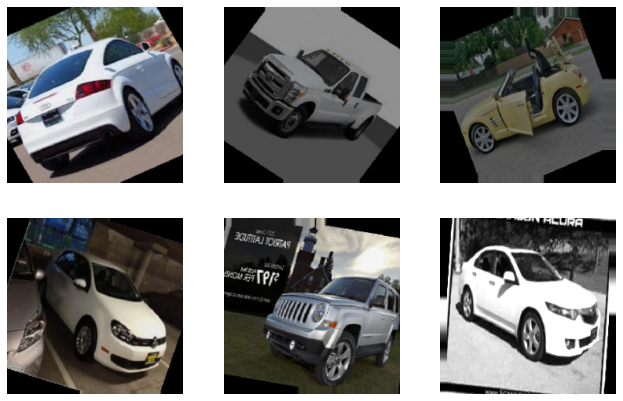

In [14]:
# Display some images
def show_transformed_images(generator, num_images=6):
    images, labels = next(generator)
    print(f"Labels: {np.argmax(labels, axis=1)}")
    plt.figure(figsize=(11,11))
    for i in range(num_images):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

show_transformed_images(train_generator)

In [15]:
def create_model(input_shape, n_classes, optimizer='adam', fine_tune=0):
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
  
  if fine_tune > 0:
    for layer in base_model.layers[:-fine_tune]:
      layer.trainable = False
  else:
    for layer in base_model.layers:
      layer.trainable = False

  top_model = base_model.output
  top_model = Flatten()(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dropout(0.2)(top_model)
  output_layer = Dense(n_classes, activation='softmax')(top_model)
  
  model = Model(inputs=base_model.input, outputs=output_layer)

  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [16]:
# Defining model
num_classes = len(train_generator.class_indices)

model = create_model(input_shape=INPUT_SHAPE, n_classes=num_classes, optimizer=Adam(learning_rate=0.0001), fine_tune=2)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [17]:
# Callbacks
plot_loss = PlotLossesCallback()
checkpoint = ModelCheckpoint(best_cars_model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

In [18]:
# Train the model
history = model.fit(
  train_generator,
  epochs=N_EPOCHS,
  validation_data=test_generator,
  callbacks=[checkpoint, early_stop, plot_loss],
  verbose=1
)

Epoch 1/100
240/302 [======================>.......] - ETA: 38s - loss: 5.1044 - acc: 0.0312

KeyboardInterrupt: 

In [ ]:
# Load the best model
best_model = load_model(best_cars_model_path)

# Evaluation
train_loss, train_acc = best_model.evaluate(train_generator, verbose=0)
print(f'Train loss: {train_loss}')
print(f'Train accuracy: {train_acc}')

test_loss, train_acc = best_model.evaluate(test_generator, verbose=0)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {train_acc}')

Train loss: 3.759753465652466
Train accuracy: 0.2061396688222885
Test loss: 4.783787250518799
Test accuracy: 0.06720098853111267


In [ ]:
# Prediction and metrics
predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

26/26 [==============================] - 11s 428ms/step


In [ ]:
confusion_mtx = confusion_matrix(true_classes, predicted_classes)
confusion_mtx

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
print('Classification Report')
print(classification_report(true_classes, predicted_classes))

Classification Report
              precision    recall  f1-score   support

           0       0.17      0.62      0.27         8
           1       0.25      0.14      0.18         7
           2       0.00      0.00      0.00         2
           3       0.03      0.14      0.05         7
           4       0.04      0.22      0.07         9
           5       0.00      0.00      0.00        10
           6       0.04      0.20      0.07         5
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00         4
          11       0.20      0.18      0.19        11
          12       0.00      0.00      0.00         9
          13       0.00      0.00      0.00         8
          14       0.25      0.09      0.13        11
          15       0.00      0.00      0.00        12
          16       0.00      0.00      0.00        13
     

c:\Users\rauls\anaconda3\envs\directML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rauls\anaconda3\envs\directML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rauls\anaconda3\envs\directML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
